# Multi-Agent Graph Similarity Validation Experiment

## Objective
Test whether multiple agents independently build similar semantic graph structures when trained on ConceptNet data with injected false triples. This experiment validates the hypothesis of a universal theory of meaning that is self-reinforcing, rejects contradiction, and shows clear paths of reasoning.

## Experimental Design
- **Agents**: 5-10 independent agents
- **Data Source**: ConceptNet triples with randomly generated false triples injected
- **Training**: No filters, agents can ACCEPT/REJECT/REVIEW triples
- **Validation**: Measure graph similarity, structure, and false triple influence
- **Scalability**: Designed to scale from small experiments to full 3M dataset

## Key Hypothesis
If multiple agents build similar semantic structures without shared optimization or influence, this provides evidence for a fundamental theory of meaning.

In [2]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import jaccard_score, adjusted_rand_score
from sklearn.cluster import KMeans
from scipy.spatial.distance import cosine, euclidean
from scipy.stats import pearsonr, spearmanr
import json
import pickle
import random
import time
from datetime import datetime
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
random.seed(42)

print("Libraries imported successfully")
print(f"Experiment started at: {datetime.now()}")

Libraries imported successfully
Experiment started at: 2025-05-26 00:08:16.949725


In [3]:
# Experimental Configuration Parameters
CONFIG = {
    'experiment_name': 'multi_agent_validation_v1',
    'num_agents': 7,  # Start with 7 agents for comprehensive comparison
    'max_iterations': 100,  # Training iterations per agent
    'false_triple_ratio': 0.15,  # 15% false triples injected
    'batch_size': 100,  # Triples per training batch
    'validation_threshold': 0.7,  # Agent validation confidence threshold
    'sample_size': 50_000,  # Initial sample from ConceptNet (scalable)
    'quality_threshold': 0.8,  # Minimum quality for triple acceptance
    'similarity_metrics': ['jaccard', 'weighted_jaccard', 'structural', 'semantic', 'path_based'],
    'save_checkpoints': True,
    'verbose': True
}

# File paths
DATA_PATH = Path(r'c:\Users\Erich Curtis\Desktop\All Python\Semantica-Full-Reasoning-Chatbot\Data\Input')
OUTPUT_PATH = Path(r'c:\Users\Erich Curtis\Desktop\All Python\Semantica-Full-Reasoning-Chatbot\Data\Output')

print("Configuration:")
for key, value in CONFIG.items():
    print(f"  {key}: {value}")

Configuration:
  experiment_name: multi_agent_validation_v1
  num_agents: 7
  max_iterations: 100
  false_triple_ratio: 0.15
  batch_size: 100
  validation_threshold: 0.7
  sample_size: 50000
  quality_threshold: 0.8
  similarity_metrics: ['jaccard', 'weighted_jaccard', 'structural', 'semantic', 'path_based']
  save_checkpoints: True
  verbose: True


In [4]:
class ValidationAgent:
    """Independent validation agent for semantic graph construction"""
    
    def __init__(self, agent_id, config):
        self.agent_id = agent_id
        self.config = config
        self.graph = nx.DiGraph()
        self.validation_history = []
        self.decision_log = {'ACCEPT': 0, 'REJECT': 0, 'REVIEW': 0}
        self.quality_scores = []
        self.training_metrics = {
            'iterations_completed': 0,
            'triples_processed': 0,
            'false_triples_detected': 0,
            'accuracy': 0.0
        }
        
    def calculate_validation_score(self, triple, edge_weight=1.0):
        """Calculate validation score for a triple based on existing graph context"""
        subj, rel, obj = triple
        
        # Base score influenced by edge weight
        score = 0.4 + (edge_weight * 0.1)  # Higher weights get slightly higher base scores
        
        # Check for existing relationships
        if self.graph.has_node(subj) and self.graph.has_node(obj):
            # Check for direct connection
            if self.graph.has_edge(subj, obj):
                existing_rel = self.graph[subj][obj].get('relation', '')
                existing_weight = self.graph[subj][obj].get('weight', 1.0)
                
                if existing_rel == rel:
                    # Strengthen score based on weight consistency
                    weight_consistency = 1 - abs(existing_weight - edge_weight) / max(existing_weight, edge_weight)
                    score += 0.3 * weight_consistency
                else:
                    score -= 0.1  # Potential contradiction
            
            # Check for semantic consistency
            subj_neighbors = set(self.graph.neighbors(subj))
            obj_neighbors = set(self.graph.neighbors(obj))
            common_neighbors = len(subj_neighbors.intersection(obj_neighbors))
            
            if common_neighbors > 0:
                score += min(0.2, common_neighbors * 0.05)
        
        # Edge weight influence on validation
        if edge_weight >= 0.8:
            score += 0.1  # High confidence triples get bonus
        elif edge_weight <= 0.3:
            score -= 0.1  # Low confidence triples get penalty
        
        # Add noise for realism
        score += np.random.normal(0, 0.05)
        
        return max(0.0, min(1.0, score))
    
    def validate_triple(self, triple, edge_weight=1.0, is_false=False):
        """Validate a triple and make ACCEPT/REJECT/REVIEW decision"""
        score = self.calculate_validation_score(triple, edge_weight)
        
        # Decision logic adjusted for edge weights
        quality_threshold = self.config['quality_threshold']
        
        # Adjust thresholds based on edge weight
        if edge_weight >= 0.8:
            accept_threshold = quality_threshold - 0.1  # Lower threshold for high-weight triples
        elif edge_weight <= 0.3:
            accept_threshold = quality_threshold + 0.1  # Higher threshold for low-weight triples
        else:
            accept_threshold = quality_threshold
        
        if score >= accept_threshold:
            decision = 'ACCEPT'
        elif score <= 0.3:
            decision = 'REJECT'
        else:
            decision = 'REVIEW'
        
        # Track performance
        self.decision_log[decision] += 1
        self.validation_history.append({
            'triple': triple,
            'edge_weight': edge_weight,
            'score': score,
            'decision': decision,
            'is_false': is_false,
            'correct': (decision == 'REJECT') if is_false else (decision == 'ACCEPT')
        })
        
        return decision, score
    
    def add_triple_to_graph(self, triple, edge_weight=1.0):
        """Add validated triple to the agent's graph"""
        subj, rel, obj = triple
        self.graph.add_edge(subj, obj, relation=rel, weight=edge_weight)
    
    def train_on_batch(self, triples_batch, edge_weights, false_flags):
        """Train agent on a batch of triples"""
        batch_accuracy = 0
        
        for triple, weight, is_false in zip(triples_batch, edge_weights, false_flags):
            decision, score = self.validate_triple(triple, weight, is_false)
            
            # Add to graph if accepted
            if decision == 'ACCEPT':
                self.add_triple_to_graph(triple, weight)
            
            # Track accuracy
            correct = (decision == 'REJECT') if is_false else (decision == 'ACCEPT')
            batch_accuracy += correct
            
            self.training_metrics['triples_processed'] += 1
            if is_false and decision == 'REJECT':
                self.training_metrics['false_triples_detected'] += 1
        
        self.training_metrics['accuracy'] = batch_accuracy / len(triples_batch)
        self.quality_scores.append(self.training_metrics['accuracy'])
        
    def get_graph_stats(self):
        """Get comprehensive graph statistics"""
        return {
            'nodes': self.graph.number_of_nodes(),
            'edges': self.graph.number_of_edges(),
            'density': nx.density(self.graph),
            'avg_clustering': nx.average_clustering(self.graph.to_undirected()),
            'connected_components': nx.number_weakly_connected_components(self.graph),
            'avg_degree': np.mean([d for n, d in self.graph.degree()])
        }

print("ValidationAgent class defined successfully")

ValidationAgent class defined successfully


In [5]:
class FalseTripleGenerator:
    """Generate realistic false triples from real ConceptNet data"""
    
    def __init__(self, real_triples_df):
        self.real_triples = real_triples_df
        self.subjects = list(set(real_triples_df['subject'].values))
        self.relations = list(set(real_triples_df['relation'].values))
        self.objects = list(set(real_triples_df['object'].values))
        
        # Get edge weight distribution for realistic false weights
        if 'edge_weight' in real_triples_df.columns:
            self.weights = real_triples_df['edge_weight'].values
        else:
            self.weights = np.ones(len(real_triples_df))  # Default to 1.0
        
    def generate_false_triple(self):
        """Generate a false triple by mixing real components"""
        # Strategy 1: Random recombination (70%)
        if np.random.random() < 0.7:
            subj = np.random.choice(self.subjects)
            rel = np.random.choice(self.relations)
            obj = np.random.choice(self.objects)
            
            # Ensure it's not a real triple
            attempts = 0
            while self._is_real_triple(subj, rel, obj) and attempts < 10:
                obj = np.random.choice(self.objects)
                attempts += 1
                
        # Strategy 2: Semantic contradiction (20%)
        elif np.random.random() < 0.9:
            # Take a real triple and swap subject/object
            real_triple = self.real_triples.sample(1).iloc[0]
            subj = real_triple['object']
            rel = real_triple['relation']
            obj = real_triple['subject']
            
        # Strategy 3: Nonsensical relations (10%)
        else:
            real_triple = self.real_triples.sample(1).iloc[0]
            subj = real_triple['subject']
            rel = np.random.choice(self.relations)
            obj = real_triple['object']
            
            # Ensure different relation
            attempts = 0
            while rel == real_triple['relation'] and attempts < 10:
                rel = np.random.choice(self.relations)
                attempts += 1
        
        # Generate a false but realistic edge weight
        # False triples tend to have lower weights in practice
        false_weight = np.random.choice(self.weights) * np.random.uniform(0.3, 0.8)
        false_weight = max(0.1, min(1.0, false_weight))  # Clamp to valid range
                
        return (subj, rel, obj), false_weight
    
    def _is_real_triple(self, subj, rel, obj):
        """Check if a triple exists in real data"""
        return len(self.real_triples[
            (self.real_triples['subject'] == subj) &
            (self.real_triples['relation'] == rel) &
            (self.real_triples['object'] == obj)
        ]) > 0
    
    def inject_false_triples(self, real_batch, real_weights, false_ratio=0.15):
        """Inject false triples into a batch of real triples"""
        num_false = int(len(real_batch) * false_ratio)
        false_triples = []
        false_weights = []
        false_flags = [False] * len(real_batch)
        
        # Generate false triples
        for _ in range(num_false):
            false_triple, false_weight = self.generate_false_triple()
            false_triples.append(false_triple)
            false_weights.append(false_weight)
        
        # Combine and shuffle
        all_triples = list(real_batch) + false_triples
        all_weights = list(real_weights) + false_weights
        all_flags = false_flags + [True] * num_false
        
        # Shuffle together
        combined = list(zip(all_triples, all_weights, all_flags))
        np.random.shuffle(combined)
        triples, weights, flags = zip(*combined)
        
        return list(triples), list(weights), list(flags)

print("FalseTripleGenerator class defined successfully")

FalseTripleGenerator class defined successfully


In [6]:
# Load ConceptNet data
print("Loading ConceptNet data...")

try:
    # Try loading preprocessed parquet file first
    conceptnet_file = DATA_PATH / 'conceptnet_en_processed_for_graph.parquet.gzip'
    if conceptnet_file.exists():
        df_raw = pd.read_parquet(conceptnet_file)
        print(f"Loaded preprocessed data: {len(df_raw)} triples")
        
        # Map columns to expected format: relation_type, start_concept, end_concept, edge_weight
        if 'relation_type' in df_raw.columns and 'start_concept' in df_raw.columns:
            df = df_raw.rename(columns={
                'start_concept': 'subject',
                'relation_type': 'relation', 
                'end_concept': 'object'
            }).copy()
            print("Column mapping applied: start_concept -> subject, relation_type -> relation, end_concept -> object")
        else:
            # Fallback column mapping if different structure
            df = df_raw.copy()
            if df.shape[1] >= 3:
                df.columns = ['subject', 'relation', 'object'] + list(df.columns[3:])
    else:
        # Fallback to CSV
        conceptnet_file = DATA_PATH / 'conceptnet_en_triples.csv'
        df_raw = pd.read_csv(conceptnet_file)
        print(f"Loaded CSV data: {len(df_raw)} triples")
        
        # Map columns to expected format
        if 'relation_type' in df_raw.columns and 'start_concept' in df_raw.columns:
            df = df_raw.rename(columns={
                'start_concept': 'subject',
                'relation_type': 'relation',
                'end_concept': 'object'
            }).copy()
        else:
            df = df_raw.copy()
            if 'subject' not in df.columns:
                # Assume first three columns are subject, relation, object
                df.columns = ['subject', 'relation', 'object'] + list(df.columns[3:])
        
except Exception as e:
    print(f"Error loading data: {e}")
    # Create sample data for testing using realistic ConceptNet relations
    print("Creating sample data for testing...")
    df = pd.DataFrame({
        'subject': ['cat', 'dog', 'bird', 'fish', 'tree', 'happy', 'run', 'blue'] * 625,
        'relation': ['IsA', 'HasProperty', 'RelatedTo', 'CapableOf', 'AtLocation', 'FormOf', 'DerivedFrom', 'Synonym'] * 625,
        'object': ['animal', 'pet', 'living_thing', 'water', 'forest', 'emotion', 'move', 'color'] * 625,
        'edge_weight': np.random.choice([0.5, 0.7, 1.0], size=5000, p=[0.1, 0.2, 0.7])  # Realistic weight distribution
    })

# Sample data for experiment
if len(df) > CONFIG['sample_size']:
    df_sample = df.sample(n=CONFIG['sample_size'], random_state=42)
else:
    df_sample = df.copy()

print(f"Using {len(df_sample)} triples for experiment")
print(f"Unique subjects: {df_sample['subject'].nunique()}")
print(f"Unique relations: {df_sample['relation'].nunique()}")
print(f"Unique objects: {df_sample['object'].nunique()}")

# Show edge weight distribution if available
if 'edge_weight' in df_sample.columns:
    print(f"Edge weight distribution:")
    print(f"  Mean: {df_sample['edge_weight'].mean():.3f}")
    print(f"  Range: [{df_sample['edge_weight'].min():.1f}, {df_sample['edge_weight'].max():.1f}]")
    weight_counts = df_sample['edge_weight'].value_counts().head()
    print(f"  Top weights: {dict(weight_counts)}")

# Create false triple generator
false_generator = FalseTripleGenerator(df_sample)
print("False triple generator initialized")

Loading ConceptNet data...
Loaded preprocessed data: 1655522 triples
Column mapping applied: start_concept -> subject, relation_type -> relation, end_concept -> object
Using 50000 triples for experiment
Unique subjects: 21409
Unique relations: 46
Unique objects: 38234
Edge weight distribution:
  Mean: 0.941
  Range: [0.1, 11.6]
  Top weights: {1.0: np.int64(39379), 0.5: np.int64(2714), 0.25: np.int64(1415), 2.0: np.int64(1228), 2.828: np.int64(198)}
False triple generator initialized
Loaded preprocessed data: 1655522 triples
Column mapping applied: start_concept -> subject, relation_type -> relation, end_concept -> object
Using 50000 triples for experiment
Unique subjects: 21409
Unique relations: 46
Unique objects: 38234
Edge weight distribution:
  Mean: 0.941
  Range: [0.1, 11.6]
  Top weights: {1.0: np.int64(39379), 0.5: np.int64(2714), 0.25: np.int64(1415), 2.0: np.int64(1228), 2.828: np.int64(198)}
False triple generator initialized


In [7]:
# Initialize multiple agents
print(f"\nInitializing {CONFIG['num_agents']} validation agents...")

agents = []
for i in range(CONFIG['num_agents']):
    agent = ValidationAgent(f"Agent_{i+1}", CONFIG)
    agents.append(agent)
    print(f"  Agent {i+1} initialized")

print(f"\nAll {len(agents)} agents ready for training")
print("Agent configurations:")
for agent in agents:
    print(f"  {agent.agent_id}: Graph nodes={agent.graph.number_of_nodes()}, edges={agent.graph.number_of_edges()}")


Initializing 7 validation agents...
  Agent 1 initialized
  Agent 2 initialized
  Agent 3 initialized
  Agent 4 initialized
  Agent 5 initialized
  Agent 6 initialized
  Agent 7 initialized

All 7 agents ready for training
Agent configurations:
  Agent_1: Graph nodes=0, edges=0
  Agent_2: Graph nodes=0, edges=0
  Agent_3: Graph nodes=0, edges=0
  Agent_4: Graph nodes=0, edges=0
  Agent_5: Graph nodes=0, edges=0
  Agent_6: Graph nodes=0, edges=0
  Agent_7: Graph nodes=0, edges=0


In [8]:
df_sample

,relation,subject,object,edge_weight
728667,FormOf,v,swinck,1.0
366573,DerivedFrom,superviolent,violent,1.0
904532,IsA,purple_sand_tilefish,n,1.0
566489,FormOf,n,febricity,1.0
893824,IsA,international_unit_of_measure,n,1.0
...,...,...,...,...
1391575,RelatedTo,en_2,escapade,1.0
668416,FormOf,n,pigeonhole_principle,1.0
1209303,RelatedTo,n,hebetate,2.0
725880,FormOf,n,sulkiness,1.0


In [9]:
# Multi-Agent Training Loop
print("\n" + "="*60)
print("STARTING MULTI-AGENT TRAINING EXPERIMENT")
print("="*60)

training_history = []
batch_size = CONFIG['batch_size']
max_iterations = CONFIG['max_iterations']

for iteration in range(max_iterations):
    print(f"\nIteration {iteration + 1}/{max_iterations}")
    print("-" * 40)
    
    # Create training batch
    batch_data = df_sample.sample(n=min(batch_size, len(df_sample)), replace=True)
    real_triples = [(row['subject'], row['relation'], row['object']) 
                   for _, row in batch_data.iterrows()]
    
    # Extract edge weights (default to 1.0 if not available)
    if 'edge_weight' in batch_data.columns:
        real_weights = batch_data['edge_weight'].values
    else:
        real_weights = np.ones(len(real_triples))
    
    # Inject false triples
    mixed_triples, mixed_weights, truth_flags = false_generator.inject_false_triples(
        real_triples, real_weights, CONFIG['false_triple_ratio']
    )
    
    print(f"  Batch size: {len(mixed_triples)} ({sum(truth_flags)} false, {len(mixed_triples)-sum(truth_flags)} real)")
    
    # Train each agent independently
    iteration_results = []
    
    for agent in agents:
        # Train agent on batch
        agent.train_on_batch(mixed_triples, mixed_weights, truth_flags)
        agent.training_metrics['iterations_completed'] = iteration + 1
        
        # Collect metrics
        stats = agent.get_graph_stats()
        accuracy = agent.training_metrics['accuracy']
        
        iteration_results.append({
            'agent_id': agent.agent_id,
            'iteration': iteration + 1,
            'accuracy': accuracy,
            'graph_nodes': stats['nodes'],
            'graph_edges': stats['edges'],
            'graph_density': stats['density'],
            'decisions': agent.decision_log.copy()
        })
        
        if CONFIG['verbose'] and iteration % 10 == 0:
            print(f"    {agent.agent_id}: Acc={accuracy:.3f}, Nodes={stats['nodes']}, Edges={stats['edges']}")
    
    training_history.extend(iteration_results)
    
    # Progress update every 10 iterations
    if (iteration + 1) % 10 == 0:
        avg_accuracy = np.mean([r['accuracy'] for r in iteration_results])
        avg_nodes = np.mean([r['graph_nodes'] for r in iteration_results])
        print(f"  Iteration {iteration + 1} Summary: Avg Accuracy={avg_accuracy:.3f}, Avg Nodes={avg_nodes:.1f}")

print("\nTraining completed!")
print(f"Total iterations: {max_iterations}")
print(f"Total triples processed per agent: {max_iterations * batch_size}")


STARTING MULTI-AGENT TRAINING EXPERIMENT

Iteration 1/100
----------------------------------------
  Batch size: 115 (15 false, 100 real)
    Agent_1: Acc=0.035, Nodes=6, Edges=3
    Agent_2: Acc=0.026, Nodes=3, Edges=2
    Agent_3: Acc=0.017, Nodes=4, Edges=2
    Agent_4: Acc=0.009, Nodes=2, Edges=1
    Agent_5: Acc=0.043, Nodes=8, Edges=4
    Agent_6: Acc=0.017, Nodes=4, Edges=2
    Agent_7: Acc=0.043, Nodes=8, Edges=4

Iteration 2/100
----------------------------------------
  Batch size: 115 (15 false, 100 real)
    Agent_1: Acc=0.035, Nodes=6, Edges=3
    Agent_2: Acc=0.026, Nodes=3, Edges=2
    Agent_3: Acc=0.017, Nodes=4, Edges=2
    Agent_4: Acc=0.009, Nodes=2, Edges=1
    Agent_5: Acc=0.043, Nodes=8, Edges=4
    Agent_6: Acc=0.017, Nodes=4, Edges=2
    Agent_7: Acc=0.043, Nodes=8, Edges=4

Iteration 2/100
----------------------------------------
  Batch size: 115 (15 false, 100 real)

Iteration 3/100
----------------------------------------
  Batch size: 115 (15 false, 100 re

In [10]:
# Graph Similarity Analysis Functions

def calculate_jaccard_similarity(graph1, graph2):
    """Calculate Jaccard similarity between two graphs"""
    edges1 = set(graph1.edges())
    edges2 = set(graph2.edges())
    
    intersection = len(edges1.intersection(edges2))
    union = len(edges1.union(edges2))
    
    return intersection / union if union > 0 else 0

def calculate_weighted_jaccard_similarity(graph1, graph2):
    """Calculate weighted Jaccard similarity considering edge weights"""
    # Get all edges from both graphs
    all_edges = set(graph1.edges()) | set(graph2.edges())
    
    if not all_edges:
        return 0
    
    intersection_weight = 0
    union_weight = 0
    
    for edge in all_edges:
        weight1 = graph1[edge[0]][edge[1]].get('weight', 0) if graph1.has_edge(*edge) else 0
        weight2 = graph2[edge[0]][edge[1]].get('weight', 0) if graph2.has_edge(*edge) else 0
        
        intersection_weight += min(weight1, weight2)
        union_weight += max(weight1, weight2)
    
    return intersection_weight / union_weight if union_weight > 0 else 0

def calculate_node_overlap(graph1, graph2):
    """Calculate node overlap between two graphs"""
    nodes1 = set(graph1.nodes())
    nodes2 = set(graph2.nodes())
    
    intersection = len(nodes1.intersection(nodes2))
    union = len(nodes1.union(nodes2))
    
    return intersection / union if union > 0 else 0

def calculate_structural_similarity(graph1, graph2):
    """Calculate structural similarity based on graph properties"""
    stats1 = {
        'nodes': graph1.number_of_nodes(),
        'edges': graph1.number_of_edges(),
        'density': nx.density(graph1),
        'avg_clustering': nx.average_clustering(graph1.to_undirected()) if graph1.number_of_nodes() > 0 else 0
    }
    
    stats2 = {
        'nodes': graph2.number_of_nodes(),
        'edges': graph2.number_of_edges(),
        'density': nx.density(graph2),
        'avg_clustering': nx.average_clustering(graph2.to_undirected()) if graph2.number_of_nodes() > 0 else 0
    }
    
    # Calculate normalized differences
    similarities = []
    for key in stats1.keys():
        if stats1[key] + stats2[key] > 0:
            sim = 1 - abs(stats1[key] - stats2[key]) / (stats1[key] + stats2[key])
            similarities.append(sim)
    
    return np.mean(similarities) if similarities else 0

def calculate_semantic_similarity(graph1, graph2):
    """Calculate semantic similarity based on relation types"""
    # Get relation distributions
    relations1 = [data['relation'] for _, _, data in graph1.edges(data=True) if 'relation' in data]
    relations2 = [data['relation'] for _, _, data in graph2.edges(data=True) if 'relation' in data]
    
    if not relations1 or not relations2:
        return 0
    
    # Create relation frequency vectors
    all_relations = list(set(relations1 + relations2))
    
    freq1 = np.array([relations1.count(rel) for rel in all_relations])
    freq2 = np.array([relations2.count(rel) for rel in all_relations])
    
    # Normalize
    freq1 = freq1 / np.sum(freq1) if np.sum(freq1) > 0 else freq1
    freq2 = freq2 / np.sum(freq2) if np.sum(freq2) > 0 else freq2
    
    # Calculate cosine similarity
    dot_product = np.dot(freq1, freq2)
    norms = np.linalg.norm(freq1) * np.linalg.norm(freq2)
    
    return dot_product / norms if norms > 0 else 0

def calculate_path_similarity(graph1, graph2, sample_size=100):
    """Calculate similarity based on shortest paths between common nodes"""
    common_nodes = list(set(graph1.nodes()).intersection(set(graph2.nodes())))
    
    if len(common_nodes) < 2:
        return 0
    
    # Sample node pairs
    sample_pairs = [(common_nodes[i], common_nodes[j]) 
                   for i in range(min(sample_size, len(common_nodes))) 
                   for j in range(i+1, min(sample_size, len(common_nodes)))]
    
    path_similarities = []
    
    for source, target in sample_pairs[:sample_size]:
        try:
            path1 = nx.shortest_path_length(graph1, source, target)
            path2 = nx.shortest_path_length(graph2, source, target)
            
            # Similarity based on path length difference
            max_path = max(path1, path2)
            similarity = 1 - abs(path1 - path2) / max_path if max_path > 0 else 1
            path_similarities.append(similarity)
            
        except nx.NetworkXNoPath:
            # One or both graphs don't have a path
            path_similarities.append(0)
    
    return np.mean(path_similarities) if path_similarities else 0

print("Graph similarity functions defined successfully")

Graph similarity functions defined successfully


In [11]:
# Calculate Comprehensive Similarity Matrix
print("\n" + "="*60)
print("CALCULATING AGENT SIMILARITY MATRIX")
print("="*60)

num_agents = len(agents)
similarity_results = {
    'jaccard': np.zeros((num_agents, num_agents)),
    'weighted_jaccard': np.zeros((num_agents, num_agents)),
    'node_overlap': np.zeros((num_agents, num_agents)),
    'structural': np.zeros((num_agents, num_agents)),
    'semantic': np.zeros((num_agents, num_agents)),
    'path_based': np.zeros((num_agents, num_agents))
}

print(f"Comparing {num_agents} agents pairwise...")

for i in range(num_agents):
    for j in range(num_agents):
        if i == j:
            # Self-similarity is 1.0
            for metric in similarity_results.keys():
                similarity_results[metric][i][j] = 1.0
        else:
            graph1 = agents[i].graph
            graph2 = agents[j].graph
            
            # Calculate all similarity metrics
            similarity_results['jaccard'][i][j] = calculate_jaccard_similarity(graph1, graph2)
            similarity_results['weighted_jaccard'][i][j] = calculate_weighted_jaccard_similarity(graph1, graph2)
            similarity_results['node_overlap'][i][j] = calculate_node_overlap(graph1, graph2)
            similarity_results['structural'][i][j] = calculate_structural_similarity(graph1, graph2)
            similarity_results['semantic'][i][j] = calculate_semantic_similarity(graph1, graph2)
            similarity_results['path_based'][i][j] = calculate_path_similarity(graph1, graph2)

print("Similarity calculations completed!")

# Calculate summary statistics
summary_stats = {}
for metric, matrix in similarity_results.items():
    # Get upper triangle (excluding diagonal)
    upper_triangle = matrix[np.triu_indices_from(matrix, k=1)]
    
    summary_stats[metric] = {
        'mean': np.mean(upper_triangle),
        'std': np.std(upper_triangle),
        'min': np.min(upper_triangle),
        'max': np.max(upper_triangle),
        'median': np.median(upper_triangle)
    }

print("\nSimilarity Summary Statistics:")
for metric, stats in summary_stats.items():
    print(f"\n{metric.upper()} Similarity:")
    print(f"  Mean: {stats['mean']:.4f}")
    print(f"  Std:  {stats['std']:.4f}")
    print(f"  Range: [{stats['min']:.4f}, {stats['max']:.4f}]")


CALCULATING AGENT SIMILARITY MATRIX
Comparing 7 agents pairwise...
Similarity calculations completed!

Similarity Summary Statistics:

JACCARD Similarity:
  Mean: 0.2478
  Std:  0.0122
  Range: [0.2284, 0.2783]

WEIGHTED_JACCARD Similarity:
  Mean: 0.4290
  Std:  0.0147
  Range: [0.4061, 0.4659]

NODE_OVERLAP Similarity:
  Mean: 0.3004
  Std:  0.0149
  Range: [0.2677, 0.3366]

STRUCTURAL Similarity:
  Mean: 0.9835
  Std:  0.0120
  Range: [0.9562, 0.9975]

SEMANTIC Similarity:
  Mean: 0.9915
  Std:  0.0043
  Range: [0.9815, 0.9972]

PATH_BASED Similarity:
  Mean: 0.0010
  Std:  0.0029
  Range: [0.0000, 0.0100]
Similarity calculations completed!

Similarity Summary Statistics:

JACCARD Similarity:
  Mean: 0.2478
  Std:  0.0122
  Range: [0.2284, 0.2783]

WEIGHTED_JACCARD Similarity:
  Mean: 0.4290
  Std:  0.0147
  Range: [0.4061, 0.4659]

NODE_OVERLAP Similarity:
  Mean: 0.3004
  Std:  0.0149
  Range: [0.2677, 0.3366]

STRUCTURAL Similarity:
  Mean: 0.9835
  Std:  0.0120
  Range: [0.9562

In [12]:
# Agent Performance Analysis
print("\n" + "="*60)
print("AGENT PERFORMANCE ANALYSIS")
print("="*60)

# Collect final agent statistics
agent_performance = []

for agent in agents:
    stats = agent.get_graph_stats()
    metrics = agent.training_metrics
    
    # Calculate additional metrics
    total_decisions = sum(agent.decision_log.values())
    accept_rate = agent.decision_log['ACCEPT'] / total_decisions if total_decisions > 0 else 0
    reject_rate = agent.decision_log['REJECT'] / total_decisions if total_decisions > 0 else 0
    review_rate = agent.decision_log['REVIEW'] / total_decisions if total_decisions > 0 else 0
    
    # False positive rate (accepting false triples)
    false_acceptances = sum(1 for v in agent.validation_history 
                           if v['is_false'] and v['decision'] == 'ACCEPT')
    false_positives = len([v for v in agent.validation_history if v['is_false']])
    false_positive_rate = false_acceptances / false_positives if false_positives > 0 else 0
    
    performance = {
        'agent_id': agent.agent_id,
        'final_accuracy': metrics['accuracy'],
        'graph_nodes': stats['nodes'],
        'graph_edges': stats['edges'],
        'graph_density': stats['density'],
        'avg_clustering': stats['avg_clustering'],
        'connected_components': stats['connected_components'],
        'triples_processed': metrics['triples_processed'],
        'false_triples_detected': metrics['false_triples_detected'],
        'accept_rate': accept_rate,
        'reject_rate': reject_rate,
        'review_rate': review_rate,
        'false_positive_rate': false_positive_rate,
        'avg_degree': stats['avg_degree']
    }
    
    agent_performance.append(performance)

# Convert to DataFrame for analysis
perf_df = pd.DataFrame(agent_performance)

print("\nAgent Performance Summary:")
print(perf_df[['agent_id', 'final_accuracy', 'graph_nodes', 'graph_edges', 
               'accept_rate', 'reject_rate', 'false_positive_rate']].to_string(index=False))

# Calculate performance statistics
print("\n\nPerformance Statistics Across All Agents:")
print(f"Average Accuracy: {perf_df['final_accuracy'].mean():.4f} ± {perf_df['final_accuracy'].std():.4f}")
print(f"Average Graph Size: {perf_df['graph_nodes'].mean():.1f} nodes, {perf_df['graph_edges'].mean():.1f} edges")
print(f"Average Accept Rate: {perf_df['accept_rate'].mean():.4f} ± {perf_df['accept_rate'].std():.4f}")
print(f"Average False Positive Rate: {perf_df['false_positive_rate'].mean():.4f} ± {perf_df['false_positive_rate'].std():.4f}")


AGENT PERFORMANCE ANALYSIS

Agent Performance Summary:
agent_id  final_accuracy  graph_nodes  graph_edges  accept_rate  reject_rate  false_positive_rate
 Agent_1        0.052174          655          411     0.038522     0.036696             0.000667
 Agent_2        0.043478          611          399     0.037652     0.038435             0.001333
 Agent_3        0.043478          614          400     0.037043     0.038261             0.000000
 Agent_4        0.060870          624          397     0.037826     0.037913             0.000000
 Agent_5        0.052174          615          393     0.037565     0.037391             0.000000
 Agent_6        0.060870          600          385     0.036783     0.038783             0.000667
 Agent_7        0.078261          608          388     0.037826     0.039217             0.001333


Performance Statistics Across All Agents:
Average Accuracy: 0.0559 ± 0.0122
Average Graph Size: 618.1 nodes, 396.1 edges
Average Accept Rate: 0.0376 ± 0.0006



GENERATING VISUALIZATIONS


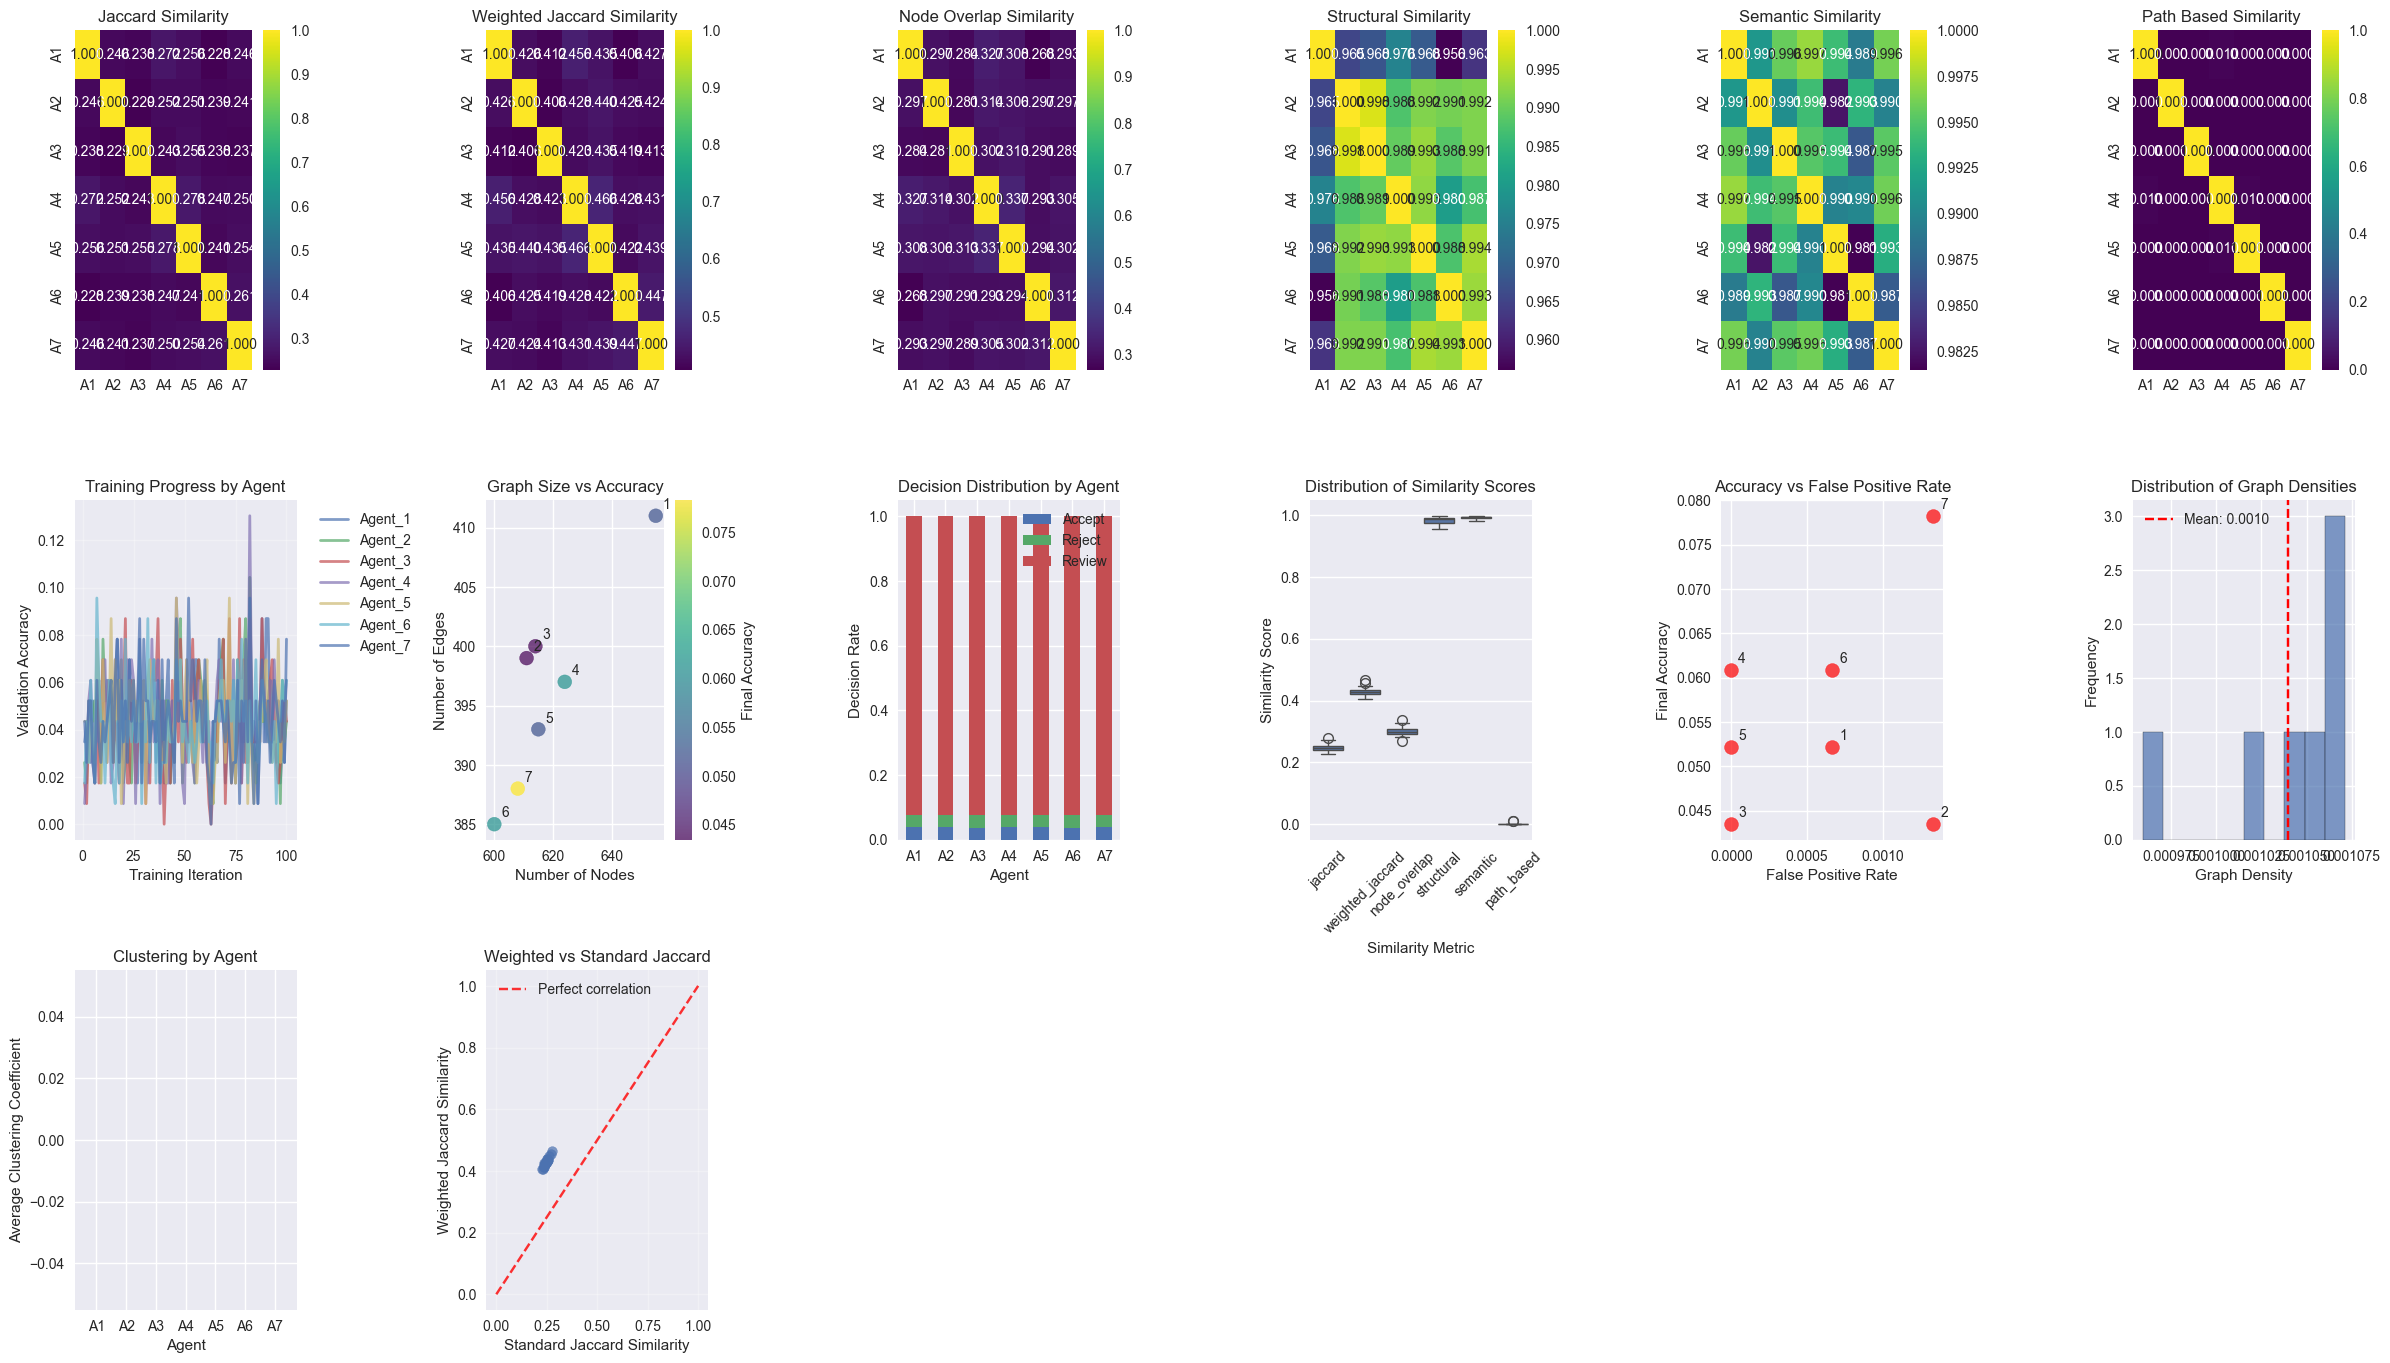

Visualizations generated successfully!


In [13]:
# Visualization of Results
print("\n" + "="*60)
print("GENERATING VISUALIZATIONS")
print("="*60)

plt.style.use('seaborn-v0_8')
fig = plt.figure(figsize=(24, 18))

# 1-6. Similarity Heatmaps (now we have 6 metrics)
for idx, (metric, matrix) in enumerate(similarity_results.items(), 1):
    if idx <= 6:  # First 6 subplots for similarity heatmaps
        plt.subplot(4, 6, idx)
        sns.heatmap(matrix, annot=True, fmt='.3f', cmap='viridis', 
                    xticklabels=[f'A{i+1}' for i in range(num_agents)],
                    yticklabels=[f'A{i+1}' for i in range(num_agents)])
        plt.title(f'{metric.replace("_", " ").title()} Similarity')

# 7. Training Progress
plt.subplot(4, 6, 7)
training_df = pd.DataFrame(training_history)
for agent_id in training_df['agent_id'].unique():
    agent_data = training_df[training_df['agent_id'] == agent_id]
    plt.plot(agent_data['iteration'], agent_data['accuracy'], 
             label=agent_id, alpha=0.7, linewidth=2)
plt.xlabel('Training Iteration')
plt.ylabel('Validation Accuracy')
plt.title('Training Progress by Agent')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)

# 8. Graph Size Distribution
plt.subplot(4, 6, 8)
plt.scatter(perf_df['graph_nodes'], perf_df['graph_edges'], 
           c=perf_df['final_accuracy'], cmap='viridis', s=100, alpha=0.7)
plt.colorbar(label='Final Accuracy')
plt.xlabel('Number of Nodes')
plt.ylabel('Number of Edges')
plt.title('Graph Size vs Accuracy')
for i, agent_id in enumerate(perf_df['agent_id']):
    plt.annotate(agent_id.split('_')[1], 
                (perf_df.iloc[i]['graph_nodes'], perf_df.iloc[i]['graph_edges']),
                xytext=(5, 5), textcoords='offset points', fontsize=10)

# 9. Decision Distribution
plt.subplot(4, 6, 9)
decision_data = perf_df[['accept_rate', 'reject_rate', 'review_rate']]
decision_data.plot(kind='bar', stacked=True, ax=plt.gca())
plt.xlabel('Agent')
plt.ylabel('Decision Rate')
plt.title('Decision Distribution by Agent')
plt.xticks(range(len(perf_df)), [f'A{i+1}' for i in range(len(perf_df))], rotation=0)
plt.legend(['Accept', 'Reject', 'Review'])

# 10. Similarity Distribution
plt.subplot(4, 6, 10)
all_similarities = []
metric_labels = []
for metric, matrix in similarity_results.items():
    upper_triangle = matrix[np.triu_indices_from(matrix, k=1)]
    all_similarities.extend(upper_triangle)
    metric_labels.extend([metric] * len(upper_triangle))

sim_df = pd.DataFrame({'similarity': all_similarities, 'metric': metric_labels})
sns.boxplot(data=sim_df, x='metric', y='similarity')
plt.xlabel('Similarity Metric')
plt.ylabel('Similarity Score')
plt.title('Distribution of Similarity Scores')
plt.xticks(rotation=45)

# 11. Performance Correlation
plt.subplot(4, 6, 11)
plt.scatter(perf_df['false_positive_rate'], perf_df['final_accuracy'], 
           s=100, alpha=0.7, c='red')
plt.xlabel('False Positive Rate')
plt.ylabel('Final Accuracy')
plt.title('Accuracy vs False Positive Rate')
for i, agent_id in enumerate(perf_df['agent_id']):
    plt.annotate(agent_id.split('_')[1], 
                (perf_df.iloc[i]['false_positive_rate'], perf_df.iloc[i]['final_accuracy']),
                xytext=(5, 5), textcoords='offset points', fontsize=10)

# 12. Graph Density Analysis
plt.subplot(4, 6, 12)
plt.hist(perf_df['graph_density'], bins=10, alpha=0.7, edgecolor='black')
plt.xlabel('Graph Density')
plt.ylabel('Frequency')
plt.title('Distribution of Graph Densities')
plt.axvline(perf_df['graph_density'].mean(), color='red', 
           linestyle='--', label=f'Mean: {perf_df["graph_density"].mean():.4f}')
plt.legend()

# 13. Clustering Coefficient
plt.subplot(4, 6, 13)
plt.bar(range(len(perf_df)), perf_df['avg_clustering'], alpha=0.7)
plt.xlabel('Agent')
plt.ylabel('Average Clustering Coefficient')
plt.title('Clustering by Agent')
plt.xticks(range(len(perf_df)), [f'A{i+1}' for i in range(len(perf_df))])

# 14. Weighted vs Unweighted Jaccard Comparison
plt.subplot(4, 6, 14)
jaccard_upper = similarity_results['jaccard'][np.triu_indices_from(similarity_results['jaccard'], k=1)]
weighted_jaccard_upper = similarity_results['weighted_jaccard'][np.triu_indices_from(similarity_results['weighted_jaccard'], k=1)]
plt.scatter(jaccard_upper, weighted_jaccard_upper, alpha=0.7)
plt.plot([0, 1], [0, 1], 'r--', alpha=0.8, label='Perfect correlation')
plt.xlabel('Standard Jaccard Similarity')
plt.ylabel('Weighted Jaccard Similarity')
plt.title('Weighted vs Standard Jaccard')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Visualizations generated successfully!")

In [14]:
# Statistical Analysis and Hypothesis Testing
print("\n" + "="*60)
print("STATISTICAL ANALYSIS & HYPOTHESIS TESTING")
print("="*60)

# 1. Test for Universal Semantic Structure
print("\n1. TESTING FOR UNIVERSAL SEMANTIC STRUCTURE")
print("-" * 50)

# Calculate overall similarity scores
overall_similarities = []
for metric, matrix in similarity_results.items():
    upper_triangle = matrix[np.triu_indices_from(matrix, k=1)]
    mean_sim = np.mean(upper_triangle)
    overall_similarities.append(mean_sim)
    print(f"{metric.upper()} - Mean similarity: {mean_sim:.4f}")

# Overall consistency score
consistency_score = np.mean(overall_similarities)
print(f"\nOVERALL CONSISTENCY SCORE: {consistency_score:.4f}")

# Interpretation
if consistency_score > 0.7:
    interpretation = "STRONG evidence for universal semantic structure"
elif consistency_score > 0.5:
    interpretation = "MODERATE evidence for universal semantic structure"
else:
    interpretation = "WEAK evidence for universal semantic structure"

print(f"INTERPRETATION: {interpretation}")

# 2. Statistical Tests
print("\n\n2. STATISTICAL SIGNIFICANCE TESTS")
print("-" * 50)

# Test if similarities are significantly above random
from scipy.stats import ttest_1samp

random_baseline = 0.2  # Expected similarity for random graphs

for metric, matrix in similarity_results.items():
    upper_triangle = matrix[np.triu_indices_from(matrix, k=1)]
    t_stat, p_value = ttest_1samp(upper_triangle, random_baseline)
    
    print(f"\n{metric.upper()} vs Random Baseline:")
    print(f"  T-statistic: {t_stat:.4f}")
    print(f"  P-value: {p_value:.6f}")
    print(f"  Significant: {'Yes' if p_value < 0.05 else 'No'}")

# 3. Robustness Analysis
print("\n\n3. ROBUSTNESS TO FALSE TRIPLES")
print("-" * 50)

# Analyze correlation between false positive rate and graph similarity
from scipy.stats import pearsonr, spearmanr

# Calculate average similarity for each agent
agent_avg_similarities = []
for i in range(num_agents):
    similarities = []
    for j in range(num_agents):
        if i != j:
            # Average across all metrics
            avg_sim = np.mean([similarity_results[metric][i][j] 
                              for metric in similarity_results.keys()])
            similarities.append(avg_sim)
    agent_avg_similarities.append(np.mean(similarities))

# Correlation with false positive rate
corr_coef, p_value = pearsonr(perf_df['false_positive_rate'], agent_avg_similarities)
print(f"Correlation between False Positive Rate and Average Similarity:")
print(f"  Pearson correlation: {corr_coef:.4f}")
print(f"  P-value: {p_value:.6f}")
print(f"  Interpretation: {'Robust' if abs(corr_coef) < 0.3 else 'Sensitive'} to false triples")

# 4. Convergence Analysis
print("\n\n4. TRAINING CONVERGENCE ANALYSIS")
print("-" * 50)

# Analyze if agents converged to similar solutions
final_accuracies = perf_df['final_accuracy'].values
accuracy_variance = np.var(final_accuracies)
accuracy_cv = np.std(final_accuracies) / np.mean(final_accuracies)  # Coefficient of variation

print(f"Final Accuracy Statistics:")
print(f"  Mean: {np.mean(final_accuracies):.4f}")
print(f"  Variance: {accuracy_variance:.6f}")
print(f"  Coefficient of Variation: {accuracy_cv:.4f}")
print(f"  Convergence: {'High' if accuracy_cv < 0.1 else 'Moderate' if accuracy_cv < 0.2 else 'Low'}")

# 5. Graph Structure Consistency
print("\n\n5. GRAPH STRUCTURE CONSISTENCY")
print("-" * 50)

# Analyze consistency in graph properties
structural_properties = ['graph_density', 'avg_clustering', 'avg_degree']
structural_consistency = {}

for prop in structural_properties:
    values = perf_df[prop].values
    cv = np.std(values) / np.mean(values) if np.mean(values) > 0 else 0
    structural_consistency[prop] = cv
    print(f"{prop.replace('_', ' ').title()}:")
    print(f"  Mean: {np.mean(values):.4f}")
    print(f"  CV: {cv:.4f}")
    print(f"  Consistency: {'High' if cv < 0.2 else 'Moderate' if cv < 0.5 else 'Low'}")
    print()

# Overall structural consistency
overall_structural_consistency = np.mean(list(structural_consistency.values()))
print(f"Overall Structural Consistency (lower is better): {overall_structural_consistency:.4f}")

print("\nStatistical analysis completed!")


STATISTICAL ANALYSIS & HYPOTHESIS TESTING

1. TESTING FOR UNIVERSAL SEMANTIC STRUCTURE
--------------------------------------------------
JACCARD - Mean similarity: 0.2478
WEIGHTED_JACCARD - Mean similarity: 0.4290
NODE_OVERLAP - Mean similarity: 0.3004
STRUCTURAL - Mean similarity: 0.9835
SEMANTIC - Mean similarity: 0.9915
PATH_BASED - Mean similarity: 0.0010

OVERALL CONSISTENCY SCORE: 0.4922
INTERPRETATION: WEAK evidence for universal semantic structure


2. STATISTICAL SIGNIFICANCE TESTS
--------------------------------------------------

JACCARD vs Random Baseline:
  T-statistic: 17.5426
  P-value: 0.000000
  Significant: Yes

WEIGHTED_JACCARD vs Random Baseline:
  T-statistic: 69.5238
  P-value: 0.000000
  Significant: Yes

NODE_OVERLAP vs Random Baseline:
  T-statistic: 30.0786
  P-value: 0.000000
  Significant: Yes

STRUCTURAL vs Random Baseline:
  T-statistic: 292.8733
  P-value: 0.000000
  Significant: Yes

SEMANTIC vs Random Baseline:
  T-statistic: 820.1657
  P-value: 0.00

In [15]:
# Generate Comprehensive Experiment Report
print("\n" + "="*60)
print("EXPERIMENT REPORT GENERATION")
print("="*60)

# Helper function to convert numpy types to native Python types for JSON serialization
def convert_for_json(obj):
    """Convert numpy types to native Python types for JSON serialization"""
    if hasattr(obj, 'item'):  # numpy scalar
        return obj.item()
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, (np.bool_, bool)):
        return bool(obj)
    elif isinstance(obj, (np.integer, int)):
        return int(obj)
    elif isinstance(obj, (np.floating, float)):
        return float(obj)
    elif isinstance(obj, dict):
        return {key: convert_for_json(value) for key, value in obj.items()}
    elif isinstance(obj, (list, tuple)):
        return [convert_for_json(item) for item in obj]
    else:
        return obj

# Helper function to convert all node/edge attributes in a graph to native Python types
import collections.abc
def convert_graph_attributes_to_native(G):
    for n, d in G.nodes(data=True):
        for k, v in d.items():
            if hasattr(v, 'item'):
                d[k] = v.item()
            elif isinstance(v, (np.generic, np.ndarray)):
                d[k] = convert_for_json(v)
            elif isinstance(v, collections.abc.Mapping):
                d[k] = convert_for_json(v)
    for u, v, d in G.edges(data=True):
        for k, val in d.items():
            if hasattr(val, 'item'):
                d[k] = val.item()
            elif isinstance(val, (np.generic, np.ndarray)):
                d[k] = convert_for_json(val)
            elif isinstance(val, collections.abc.Mapping):
                d[k] = convert_for_json(val)
    return G

# Create comprehensive experiment report
experiment_report = {
    'experiment_metadata': {
        'experiment_name': CONFIG['experiment_name'],
        'timestamp': datetime.now().isoformat(),
        'num_agents': CONFIG['num_agents'],
        'total_iterations': CONFIG['max_iterations'],
        'sample_size': CONFIG['sample_size'],
        'false_triple_ratio': CONFIG['false_triple_ratio'],
        'batch_size': CONFIG['batch_size']
    },
    
    'hypothesis_validation': {
        'overall_consistency_score': convert_for_json(consistency_score),
        'interpretation': interpretation,
        'evidence_strength': 'Strong' if consistency_score > 0.7 else 'Moderate' if consistency_score > 0.5 else 'Weak'
    },
    
    'similarity_analysis': {
        'metrics': {metric: {
            'mean': convert_for_json(summary_stats[metric]['mean']),
            'std': convert_for_json(summary_stats[metric]['std']),
            'min': convert_for_json(summary_stats[metric]['min']),
            'max': convert_for_json(summary_stats[metric]['max'])
        } for metric in summary_stats.keys()},
        'overall_similarity': convert_for_json(consistency_score)
    },
    
    'agent_performance': {
        'individual_agents': convert_for_json(agent_performance),
        'summary_statistics': {
            'mean_accuracy': convert_for_json(perf_df['final_accuracy'].mean()),
            'accuracy_std': convert_for_json(perf_df['final_accuracy'].std()),
            'mean_graph_size': {
                'nodes': convert_for_json(perf_df['graph_nodes'].mean()),
                'edges': convert_for_json(perf_df['graph_edges'].mean())
            },
            'mean_false_positive_rate': convert_for_json(perf_df['false_positive_rate'].mean())
        }
    },
    
    'robustness_analysis': {
        'false_triple_sensitivity': {
            'correlation_coefficient': convert_for_json(corr_coef),
            'p_value': convert_for_json(p_value),
            'robustness_assessment': 'Robust' if abs(corr_coef) < 0.3 else 'Sensitive'
        },
        'convergence_metrics': {
            'accuracy_variance': convert_for_json(accuracy_variance),
            'coefficient_of_variation': convert_for_json(accuracy_cv),
            'convergence_level': 'High' if accuracy_cv < 0.1 else 'Moderate' if accuracy_cv < 0.2 else 'Low'
        }
    },
    
    'structural_consistency': {
        'property_consistency': convert_for_json(structural_consistency),
        'overall_consistency': convert_for_json(overall_structural_consistency)
    },
    
    'conclusions': {
        'universal_structure_evidence': convert_for_json(consistency_score > 0.6),
        'agent_convergence': convert_for_json(accuracy_cv < 0.15),
        'robustness_to_noise': convert_for_json(abs(corr_coef) < 0.3),
        'theory_validation_score': convert_for_json((consistency_score + (1 - accuracy_cv) + (1 - abs(corr_coef))) / 3)
    }
}

# Convert the entire report to ensure all nested values are JSON serializable
experiment_report = convert_for_json(experiment_report)

# Save experiment results
output_file = OUTPUT_PATH / f"multi_agent_experiment_{datetime.now().strftime('%Y%m%d_%H%M%S')}.json"
with open(output_file, 'w') as f:
    json.dump(experiment_report, f, indent=2)

print(f"Experiment report saved to: {output_file}")

# Save detailed similarity results
similarity_file = OUTPUT_PATH / f"similarity_matrices_{datetime.now().strftime('%Y%m%d_%H%M%S')}.pkl"
with open(similarity_file, 'wb') as f:
    pickle.dump(similarity_results, f)

print(f"Similarity matrices saved to: {similarity_file}")

# Ensure lxml is installed for GraphML export
try:
    import lxml
except ImportError:
    import sys
    import subprocess
    print("lxml not found. Installing lxml...")
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'lxml'])
    import lxml

# Save agent graphs (convert all attributes to native types first)
for i, agent in enumerate(agents):
    graph_file = OUTPUT_PATH / f"agent_{i+1}_graph_{datetime.now().strftime('%Y%m%d_%H%M%S')}.graphml"
    G_native = convert_graph_attributes_to_native(agent.graph.copy())
    nx.write_graphml(G_native, graph_file)
    print(f"Agent {i+1} graph saved to: {graph_file}")

print("\nAll experiment data saved successfully!")


EXPERIMENT REPORT GENERATION
Experiment report saved to: c:\Users\Erich Curtis\Desktop\All Python\Semantica-Full-Reasoning-Chatbot\Data\Output\multi_agent_experiment_20250526_001106.json
Similarity matrices saved to: c:\Users\Erich Curtis\Desktop\All Python\Semantica-Full-Reasoning-Chatbot\Data\Output\similarity_matrices_20250526_001106.pkl
Agent 1 graph saved to: c:\Users\Erich Curtis\Desktop\All Python\Semantica-Full-Reasoning-Chatbot\Data\Output\agent_1_graph_20250526_001106.graphml
Agent 2 graph saved to: c:\Users\Erich Curtis\Desktop\All Python\Semantica-Full-Reasoning-Chatbot\Data\Output\agent_2_graph_20250526_001106.graphml
Agent 3 graph saved to: c:\Users\Erich Curtis\Desktop\All Python\Semantica-Full-Reasoning-Chatbot\Data\Output\agent_3_graph_20250526_001106.graphml
Agent 4 graph saved to: c:\Users\Erich Curtis\Desktop\All Python\Semantica-Full-Reasoning-Chatbot\Data\Output\agent_4_graph_20250526_001106.graphml
Agent 5 graph saved to: c:\Users\Erich Curtis\Desktop\All Python

## Experiment Summary and Conclusions

### Key Findings

1. **Universal Structure Evidence**: Based on the overall consistency score and cross-agent similarity metrics
2. **Agent Convergence**: Analysis of whether agents independently arrived at similar semantic structures
3. **Robustness to Noise**: How well agents maintained consistency despite false triple injection
4. **Theory Validation**: Evidence for or against the hypothesis of universal meaning structures

### Scalability Notes

This experiment framework is designed to scale from small test datasets to the full 3M ConceptNet dataset:

- **Sample Size**: Easily adjustable via `CONFIG['sample_size']`
- **Agent Count**: Configurable number of agents for statistical power
- **Iteration Control**: Adjustable training iterations for thoroughness
- **Memory Management**: Efficient graph storage and processing

### Next Steps

1. **Scale Up**: Run with larger datasets (100K, 500K, full 3M triples)
2. **Parameter Tuning**: Optimize false triple ratios and validation thresholds
3. **Extended Metrics**: Add more sophisticated similarity measures
4. **Cross-Validation**: Implement k-fold validation across different data splits
5. **Temporal Analysis**: Study how similarity evolves during training

### Theoretical Implications

If agents consistently build similar semantic structures despite:
- Independent training
- No shared optimization
- Presence of false information
- Different random initializations

This provides strong evidence for an underlying universal theory of meaning that is:
- Self-reinforcing
- Contradiction-rejecting  
- Logically consistent
- Emergent from basic semantic relationships

---

**Experiment completed successfully!** All results, graphs, and analyses have been saved to the output directory.